In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats.stats import ttest_ind, sem
from matplotlib import pyplot as plt
from magicbox.algorithm.plot import plot_bar, auto_bar_width
from cxy_hcp_ffa.lib.predefine import proj_dir, roi2label

anal_dir = pjoin(proj_dir, 'analysis/s2/1080_fROI/refined_with_Kevin')
calc_dir = pjoin(anal_dir, 'NI_R1')
work_dir = pjoin(calc_dir, 'plot')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# plot CNR

#vtx of pFus: 8100
#vtx of mFus: 8256
Ttest_indResult(statistic=46.94635613147561, pvalue=0.0)


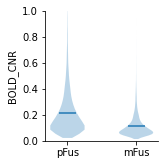

In [5]:
meas_name = 'BOLD_CNR'
figsize = (2.4, 2.4)
cnr_file = pjoin(calc_dir, f'{meas_name}.pkl')
Hemis = ('L', 'R')
roi_names = ('pFus', 'mFus')
out_file = pjoin(work_dir, f'{meas_name}.jpg')

cnr_dict = pkl.load(open(cnr_file, 'rb'))
n_roi = len(roi_names)
x = np.arange(1, n_roi + 1)
data_points = []
fig, ax = plt.subplots(figsize=figsize)
for roi_name in roi_names:
    data_points_tmp = []
    for Hemi in Hemis:
        data = cnr_dict[f'{Hemi}_{roi_name}']
        non_nan_idx_mat = ~np.isnan(data)
        data_points_tmp.append(data[non_nan_idx_mat])
    data_points.append(np.concatenate(data_points_tmp, 0))
    print(f'#vtx of {roi_name}:', len(data_points[-1]))
print(ttest_ind(*data_points))
ax.violinplot(data_points, x, showmeans=True, showextrema=False)
ax.set_xticks(x)
ax.set_xticklabels(roi_names)
ax.set_ylabel(meas_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if meas_name == 'BOLD_CNR':
    ax.set_ylim(0, 1)

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

# plot_fus_pattern_corr

#singleOrNot-lh-G0: 48
#singleOrNot-lh-G1: 1032
singleOrNot-lh: Ttest_indResult(statistic=14.258309357667192, pvalue=4.0460108865155686e-46)
#singleOrNot-rh-G0: 51
#singleOrNot-rh-G1: 1029
singleOrNot-rh: Ttest_indResult(statistic=26.25028724732622, pvalue=8.555172645154881e-152)


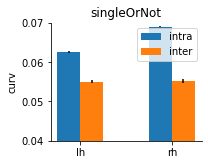

In [3]:
grouping_type = 'singleOrNot'
# grouping_type = 'separateOrNot'
# grouping_type = '3group'

# meas_name = 'myelin'
# meas_name = 'thickness'
meas_name = 'curv'
# meas_name = 'GBC'
# meas_name = 'activ'

if grouping_type == 'separateOrNot' and meas_name == 'activ':
    ylim = (0.2, 0.3)
elif grouping_type == 'separateOrNot' and meas_name == 'myelin':
    ylim = (0.56, 0.63)
elif grouping_type == 'separateOrNot' and meas_name == 'thickness':
    ylim = (0.14, 0.19)
elif grouping_type == 'separateOrNot' and meas_name == 'GBC':
    ylim = (0.35, 0.45)
elif grouping_type == '3group' and meas_name == 'GBC':
    ylim = (0.35, 0.45)
elif grouping_type == '3group' and meas_name == 'thickness':
    ylim = (0.14, 0.19)
elif grouping_type == '3group' and meas_name == 'myelin':
    ylim = (0.56, 0.63)
elif grouping_type == '3group' and meas_name == 'activ':
    ylim = (0.2, 0.3)
elif grouping_type == 'singleOrNot' and meas_name == 'activ':
    ylim = (0.15, 0.3)
elif grouping_type == 'singleOrNot' and meas_name == 'curv':
    ylim = (0.04, 0.07)
else:
    ylim = None

labels = ('intra', 'inter')
hemis = ('lh', 'rh')
hemi2Hemi = {'lh': 'L', 'rh': 'R'}
mask_name = 'union1'
data_file = pjoin(calc_dir, f'Fus-pattern-corr_{mask_name}_{meas_name}.pkl')
gid_file = pjoin(anal_dir, 'grouping/group_id_v2_012.csv')
out_file = pjoin(work_dir, f'Fus-pattern-corr_{mask_name}_{meas_name}_{grouping_type}.jpg')

data = pkl.load(open(data_file, 'rb'))

# prepare gids
df = pd.read_csv(gid_file)
if grouping_type == 'singleOrNot':
    gids = (0, 1)
    df[df == 2] = 1
elif grouping_type == 'separateOrNot':
    gids = (1, 2)
    df[df == 0] = 1
elif grouping_type == '3group':
    gids = (0, 1, 2)
else:
    raise ValueError

# prepare x, y
n_hemi = len(hemis)
ys = np.zeros((2, n_hemi))
yerrs = np.zeros((2, n_hemi))
for hemi_idx, hemi in enumerate(hemis):
    corr_arr = data[f'{hemi2Hemi[hemi]}_Fus']
    gid_vec = np.array(df[hemi])
    intra_vec = []
    inter_vec = []
    for gid in gids:
        gid_idx_vec = gid_vec == gid
        non_gid_idx_vec = ~gid_idx_vec
        n_subj_group = np.sum(gid_idx_vec)
        print(f'#{grouping_type}-{hemi}-G{gid}:', n_subj_group)

        intra_arr = corr_arr[gid_idx_vec][:, gid_idx_vec]
        assert n_subj_group == intra_arr.shape[0]
        assert n_subj_group == intra_arr.shape[1]
        tri_mat = np.tri(n_subj_group, k=-1, dtype=bool)
        intra_arr = intra_arr[tri_mat]
        intra_vec.extend(intra_arr[~np.isnan(intra_arr)])

        inter_arr = corr_arr[gid_idx_vec][:, non_gid_idx_vec]
        assert n_subj_group == inter_arr.shape[0]
        assert n_subj_group + inter_arr.shape[1] == 1080
        inter_vec.extend(inter_arr[~np.isnan(inter_arr)])
    ys[0, hemi_idx] = np.mean(intra_vec)
    yerrs[0, hemi_idx] = sem(intra_vec)
    ys[1, hemi_idx] = np.mean(inter_vec)
    yerrs[1, hemi_idx] = sem(inter_vec)
    print(f'{grouping_type}-{hemi}:', ttest_ind(intra_vec, inter_vec))

# plot
plot_bar(
    ys, n_row=1, n_col=1, figsize=(3, 2.4), yerr=yerrs, x=None, width=None,
    label=labels, color=None, show_height=None, mode=out_file, xlabel=None,
    xticklabel=hemis, rotate_xticklabel=False, ylabel=meas_name, ylim=ylim, title=grouping_type
)

# myelin and thickness gradient distribution

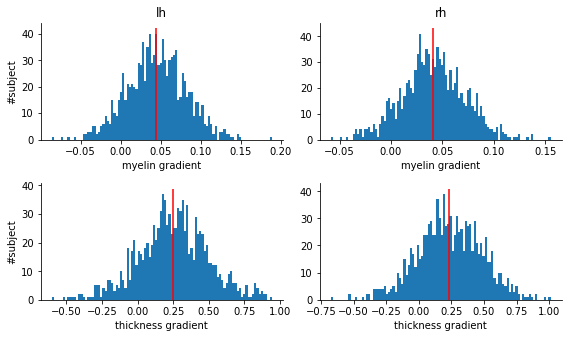

In [2]:
figsize = (8, 4.8)
meas_names = ('myelin', 'thickness')
meas2rois = {
    'myelin': ('pFus-face', 'mFus-face'),
    'thickness': ('mFus-face', 'pFus-face')}
hemis = ('lh', 'rh')
meas_file = pjoin(anal_dir, 'structure/MPM_v3_{hemi}_0.25_{meas}.pkl')
mpm_file = pjoin(anal_dir, 'MPM_v3_{hemi}_0.25.nii.gz')
meas_mean_file = pjoin(anal_dir, 'structure/{meas}_mean-1080_{hemi}.nii.gz')
out_file = pjoin(work_dir, 'M-or-T_gradient.jpg')

n_row = len(meas_names)
n_col = len(hemis)
fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
for col_idx, hemi in enumerate(hemis):
    mpm_map = nib.load(mpm_file.format(hemi=hemi)).get_fdata()
    for row_idx, meas_name in enumerate(meas_names):
        ax = axes[row_idx, col_idx]
        rois = meas2rois[meas_name]
        data = pkl.load(open(meas_file.format(hemi=hemi, meas=meas_name), 'rb'))
        roi_idx1 = data['roi'].index(rois[0])
        roi_idx2 = data['roi'].index(rois[1])
        diffs = data['meas'][roi_idx1] - data['meas'][roi_idx2]
        ax.hist(diffs, bins=100, orientation='vertical')
        ymin, ymax = ax.get_ylim()

        meas_mean_map = nib.load(meas_mean_file.format(
            meas=meas_name, hemi=hemi)).get_fdata()
        roi_idx_map1 = mpm_map == roi2label[rois[0]]
        roi_idx_map2 = mpm_map == roi2label[rois[1]]
        diff = np.mean(meas_mean_map[roi_idx_map1]) - np.mean(meas_mean_map[roi_idx_map2])
        ax.vlines(diff, ymin, ymax, colors='r')

        ax.set_xlabel(f'{meas_name} gradient')
        if col_idx == 0:
            ax.set_ylabel('#subject')
        if row_idx == 0:
            ax.set_title(hemi)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(out_file)


# Figure 1C/D

#lh_pFus-mFus: 781
#rh_pFus-mFus: 708


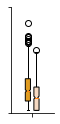

In [2]:
# method = 'peak'
# figsize = (3.56, 3.65)
# figsize = (1.78, 1.825)
# gids = (2, 1)

method = 'min1'
figsize = (0.945, 1.825)
gids = (2,)

method2ylim = {
    'peak': (0, 6),
    'min1': (-0.1, 3.5)}

gid2name = {1: 'continuous', 2: 'separate'}
gid_file = pjoin(anal_dir, 'grouping/group_id_v2.csv')

hemis = ('lh', 'rh')
hemi2color = {
    'lh': (0.88, 0.61, 0.13, 1.00),
    'rh': (0.96, 0.85, 0.76, 1.00)}
data_file = pjoin(anal_dir, f'gdist_{method}.csv')

# out_file = None
out_file = pjoin(work_dir, f'grouping_distance_{method}.svg')

n_gid = len(gids)
n_hemi = len(hemis)
gid_df = pd.read_csv(gid_file)
df = pd.read_csv(data_file)

fig, ax = plt.subplots(figsize=figsize)
x = np.arange(n_gid)
width = 0.25
offset = -(n_hemi - 1) / 2
for hemi_idx, hemi in enumerate(hemis):
    col = f'{hemi}_pFus-mFus'
    dataset = []
    for gid_idx, gid in enumerate(gids):
        gid_idx_vec = gid_df[hemi] == gid
        data = np.array(df[col])[gid_idx_vec]
        data = data / 10
        print(f'#{col}: {len(data)}')
        dataset.append(data)

    bplot = ax.boxplot(
        dataset, positions=x + width * offset,
        patch_artist=True, notch=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(hemi2color[hemi])
    offset += 1

ax.set_xticks(x)
ax.set_xticklabels(gids)
# ax.set_ylabel('cm')
ax.set_ylim(*method2ylim[method])
ax.set_yticks(method2ylim[method])
ax.set_yticklabels(method2ylim[method])
# ax.set_title(method)
ax.tick_params(bottom=True, labelbottom=False, labelleft=False, left=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)